In [1]:
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))

In [2]:
import bartz
from stochtree import BARTModel
from bart_playground import *

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import arviz as az
import time

INFO:arviz.preview:arviz_base not installed
INFO:arviz.preview:arviz_stats not installed
INFO:arviz.preview:arviz_plots not installed


In [4]:
from pmlb import fetch_data

X, y = fetch_data('1201_BNG_breastTumor', return_X_y=True)

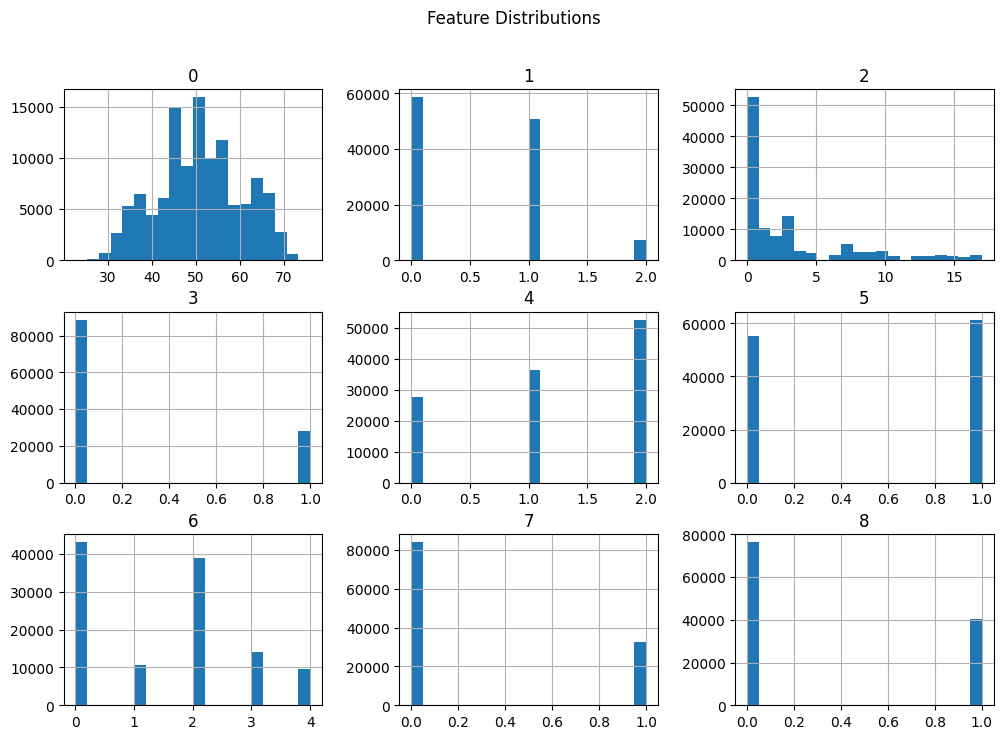

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

X_df = pd.DataFrame(X)
X_df.hist(figsize=(12, 8), bins=20)
plt.suptitle("Feature Distributions")
plt.show()

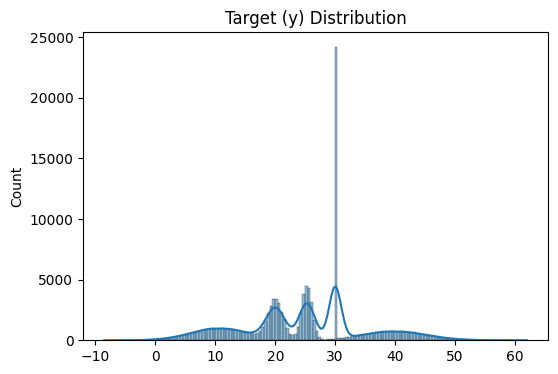

In [6]:
plt.figure(figsize=(6, 4))
sns.histplot(y, kde=True)
plt.title("Target (y) Distribution")
plt.show()

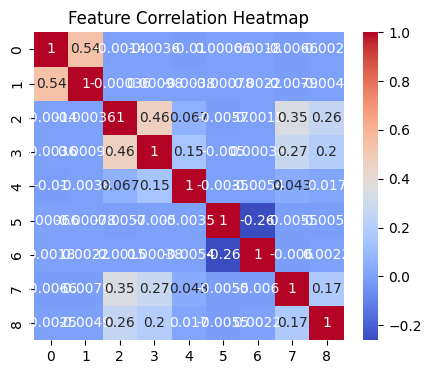

In [7]:
plt.figure(figsize=(5, 4))
corr = X_df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

In [8]:
import comparison
import pandas as pd

rhat_df = comparison.gelman_rubin_r_compare(X, y, n_runs=10, n_chains=4, ndpost=1000, nskip=1000, n_trees=100, n_jobs=-2)
mean_row = pd.DataFrame([rhat_df.mean()], index=["mean"])
std_row = pd.DataFrame([rhat_df.std()], index=["std"])
rhat_df_with_stats = pd.concat([rhat_df, mean_row, std_row])
print("Gelman-Rubin R̂ comparison matrix:")
print(rhat_df_with_stats)

Gelman-Rubin R̂ comparison matrix:
      MultiBART_Rhat_Sigma2  DefaultBART_Rhat_Sigma2  MultiBART_Rhat_RMSE  \
0                  1.002851                 1.016065             1.432765   
1                  1.004128                 1.012345             1.625623   
2                  1.011454                 1.048281             1.280026   
3                  1.012941                 1.051352             1.611181   
4                  1.011732                 1.002399             1.815398   
5                  1.003463                 1.023907             1.442830   
6                  1.007960                 1.042842             1.359847   
7                  1.009191                 1.018784             1.105700   
8                  1.011383                 1.043184             1.461737   
9                  1.015691                 1.059024             1.470054   
mean               1.009079                 1.031818             1.460516   
std                0.004381              

In [9]:
rhat_df.to_csv("results/real5_BreastTumor_rhat.csv", index=False)

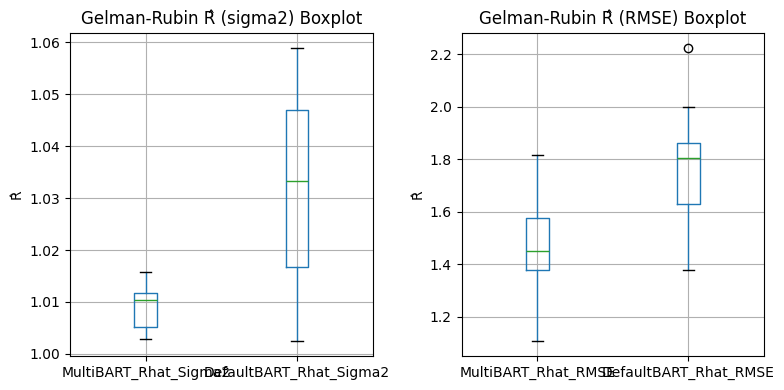

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# sigma2 boxplot
rhat_df[["MultiBART_Rhat_Sigma2", "DefaultBART_Rhat_Sigma2"]].boxplot(ax=axes[0])
axes[0].set_title("Gelman-Rubin R̂ (sigma2) Boxplot")
axes[0].set_ylabel("R̂")

# rmse boxplot
rhat_df[["MultiBART_Rhat_RMSE", "DefaultBART_Rhat_RMSE"]].boxplot(ax=axes[1])
axes[1].set_title("Gelman-Rubin R̂ (RMSE) Boxplot")
axes[1].set_ylabel("R̂")

plt.tight_layout()
plt.show()

test_mse:
      bart_mtmh       bart        btz          rf        xgb
0     87.227633  87.410128  87.289641  109.458282  88.657922
1     87.363049  87.655353  87.319037  109.713743  88.580468
2     87.731431  87.949640  87.548842  110.045747  88.964341
3     87.797708  88.127054  87.834758  110.812855  89.112601
4     88.585672  88.835211  88.603959  110.663165  90.279935
5     87.632690  87.999323  87.901895  110.808684  89.136747
6     87.977372  88.054099  87.892939  111.041204  89.535712
7     88.165358  88.275885  88.076816  110.612982  89.441630
8     88.374497  88.673057  88.499003  111.407565  89.900800
9     87.417678  87.525935  87.466861  110.821577  88.721746
mean  87.827309  88.050569  87.843375  110.538580  89.233190
std    0.447489   0.461182   0.456904    0.609861   0.556879



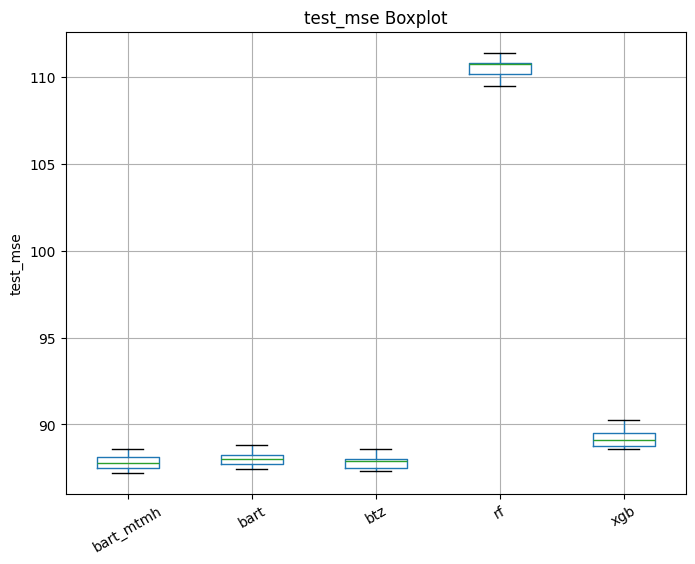

train_mse:
      bart_mtmh       bart        btz         rf        xgb
0     87.245690  87.769834  87.572981  15.534903  81.455847
1     87.375415  87.788394  87.598075  15.447441  81.404006
2     87.145371  87.711382  87.409541  15.395193  81.251570
3     87.111523  87.558678  87.548165  15.370045  81.250468
4     86.878991  87.255096  87.244632  15.341230  81.338999
5     87.149674  87.517287  87.536500  15.404729  81.252545
6     87.172065  87.433773  87.451229  15.432257  81.214583
7     87.152250  87.407355  87.415487  15.364956  81.153972
8     87.001188  87.326800  87.219002  15.369475  81.192552
9     87.185158  87.569505  87.615570  15.472823  81.257820
mean  87.141732  87.533810  87.461118  15.413305  81.277236
std    0.132542   0.182802   0.140914   0.059235   0.094540



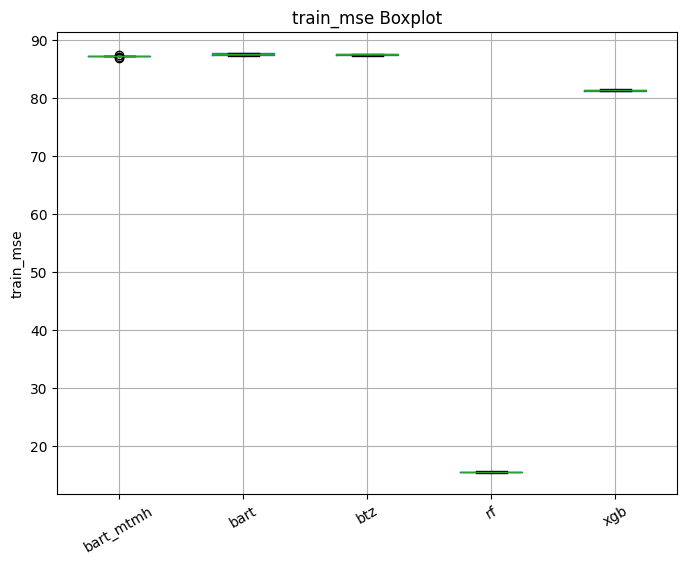

pi_length:
      bart_mtmh       bart        btz
0     36.592957  36.657009  36.719723
1     36.598409  36.669524  36.720791
2     36.557466  36.638991  36.689499
3     36.559862  36.606641  36.673428
4     36.507575  36.553269  36.614216
5     36.566729  36.603125  36.714100
6     36.596351  36.609164  36.669651
7     36.559993  36.597753  36.669243
8     36.533535  36.569297  36.645081
9     36.586073  36.600897  36.713299
mean  36.565895  36.610567  36.682899
std    0.029280   0.036144   0.035484



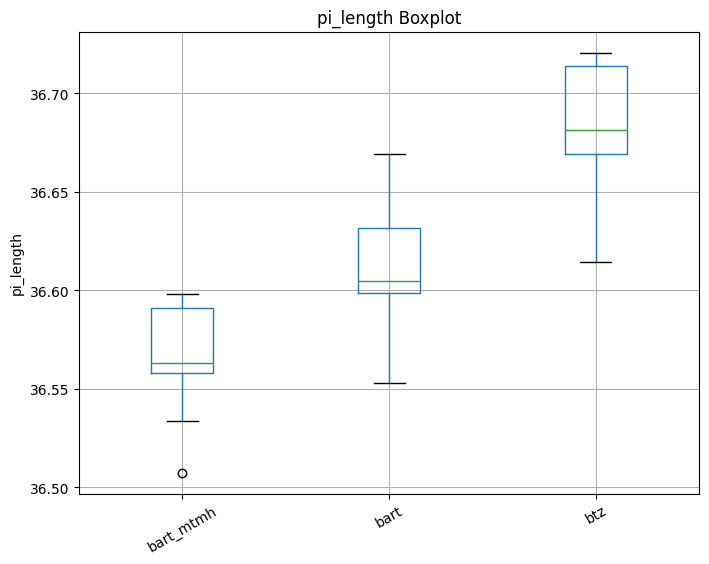

coverage:
      bart_mtmh      bart       btz
0      0.937140  0.937311  0.938649
1      0.936626  0.937414  0.937963
2      0.936385  0.936900  0.938100
3      0.935802  0.936557  0.937140
4      0.935254  0.935802  0.935871
5      0.938100  0.937483  0.938820
6      0.935871  0.935528  0.936831
7      0.937277  0.937929  0.939266
8      0.936180  0.936591  0.936591
9      0.936728  0.935905  0.937140
mean   0.936536  0.936742  0.937637
std    0.000829  0.000808  0.001093



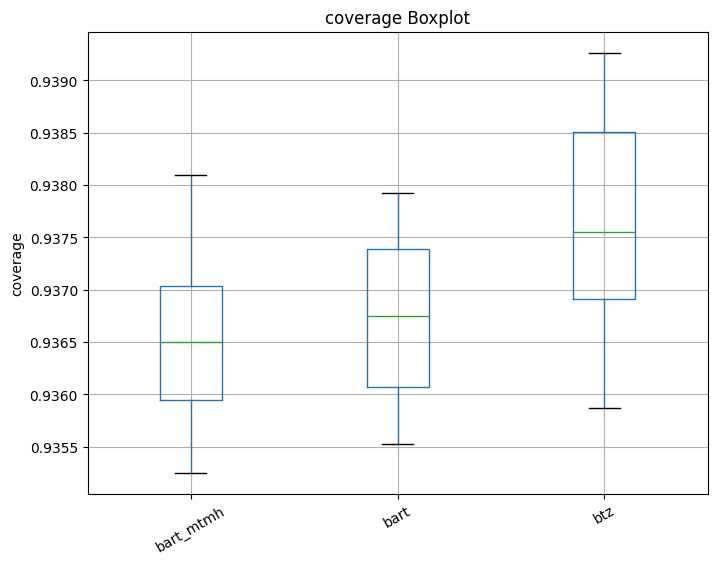

train_time:
        bart_mtmh        bart         btz          rf       xgb
0     4440.922001  934.515265  293.866526  126.559851  2.073513
1     4540.274500  995.351975  293.489503   40.181284  1.181825
2     4459.645972  936.867763  314.563358   97.104247  1.584402
3     4518.770906  986.980927  302.750670   47.462615  1.795497
4     4494.121450  959.137244  314.442099   62.109746  2.526780
5     4536.734993  999.250438  287.769593   42.113711  1.325948
6     4469.983309  971.682159  325.690010   62.507115  2.342917
7     4462.179674  952.439829  304.822215   91.203836  4.108798
8     4499.474940  979.392959  305.176451   54.889854  2.936763
9     4458.950170  957.587646  297.511629   95.280537  3.552463
mean  4488.105792  967.320621  304.008206   71.941280  2.342891
std     35.085733   22.957125   11.611209   28.879308  0.960194



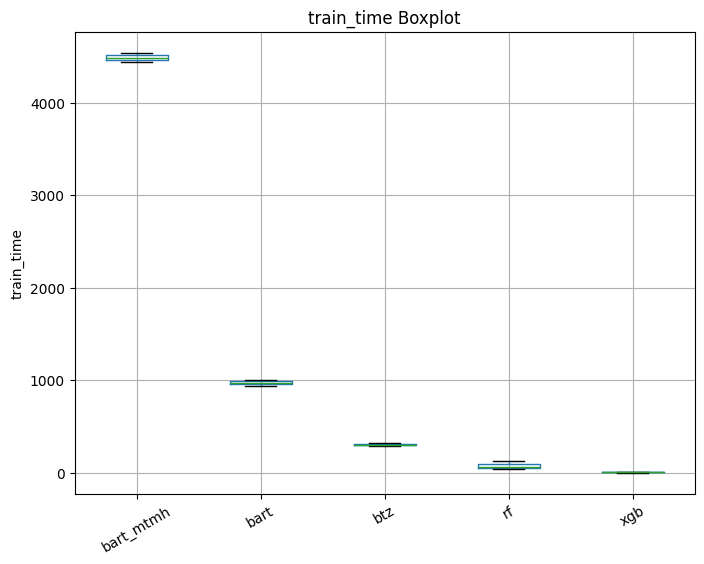

In [11]:
import matplotlib.pyplot as plt
import comparison
import pandas as pd

mse_results = comparison.bart_mse_comparison(X, y, n_runs=10, n_skip=1000, n_post=1000, n_trees=100, n_jobs=-2)
for k, v in mse_results.items():
    mean_row = pd.DataFrame([v.mean()], index=["mean"])
    std_row = pd.DataFrame([v.std()], index=["std"])
    v_with_stats = pd.concat([v, mean_row, std_row])
    print(f"{k}:\n{v_with_stats}\n")
    
    plt.figure(figsize=(8, 6))
    v.boxplot()
    plt.title(f"{k} Boxplot")
    plt.ylabel(k)
    plt.xticks(rotation=30)
    plt.show()

In [12]:
for k, v in mse_results.items():
    csv_name = f"results/real5_BreastTumor_{k}.csv"
    v.to_csv(csv_name, index=False)

## Multi-tries

In [ ]:
from multi_tries import multi_tries_performance
import pandas as pd

csv_path = "results/real5_BreastTumor_tries.csv"
existing_df = None

if os.path.exists(csv_path):
    existing_df = pd.read_csv(csv_path)

df = multi_tries_performance(
    X, y,
    multi_tries_list=[1, 5, 10, 50],
    n_runs=5, n_chains=4,
    ndpost=1000, nskip=1000, n_trees=100, n_jobs=5
)

if existing_df is not None:
    df = pd.concat([existing_df, df], ignore_index=True)
    df = df.sort_values(by='multi_tries', ascending=True).reset_index(drop=True)

df.to_csv("results/real5_BreastTumor_tries.csv", index=False)

In [ ]:
print(df)